In [84]:
initial_path = 'peptide-QML/'
initial_path = '../'

In [85]:
day = "0810"
name_notebook = day + "-mh_em_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [86]:
import numpy as np

In [87]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [88]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_8_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [89]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [90]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

# Quantum node

In [91]:
n_aminoacids = len(string_list[0])

In [92]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    final_ansatz = qn.parts.Ansatz_final_11,
    measurement = qn.parts.Measurement('Z', 3),
    # embedding_n_layers = 4,
    # different_inputs_per_layer = True,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

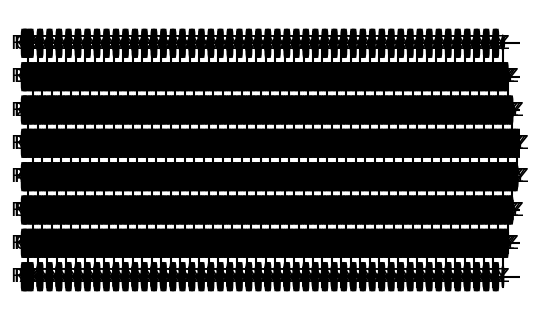

In [93]:
quantum_layer.draw(size=(20,3))

# Hybrid model

In [94]:
import torch.nn as nn
import torch
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [95]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer(), ptm.nn.Linear(1,1)]


In [96]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [97]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[0.2987],
        [0.2252]], grad_fn=<AddmmBackward0>)
tensor([0.2252], grad_fn=<AddBackward0>)


In [98]:
model.keep_track_params=False

In [99]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.2},
    num_epochs = 10,                
    batch_size = 32,
    # initialization_options = [
    #     {
    #         'type': 'normal_',
    #         'layer': len(model.model)-1, 
    #         'name': 'bias',
    #         'options': {'mean': 100, 'std': 10},
    #     },{
    #         'type': 'normal_',
    #         'layer': len(model.model)-1,
    #         'name': 'weight',
    #         'options': {'mean': 200, 'std': 10},
    #     },
    # ]
)

KeyboardInterrupt: 

In [ ]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0809/txts/0809-sh_em_1qm_v2_model_str_4.txt


Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_batches_4.png


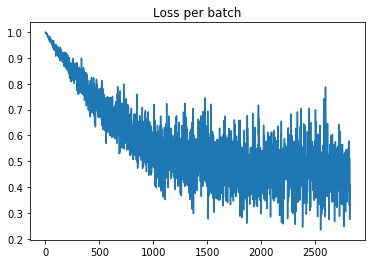

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_4.png


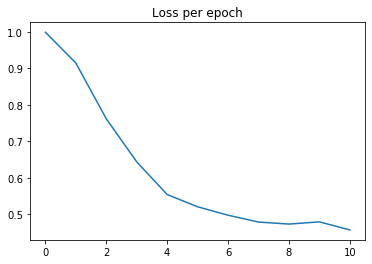

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_validation_4.png


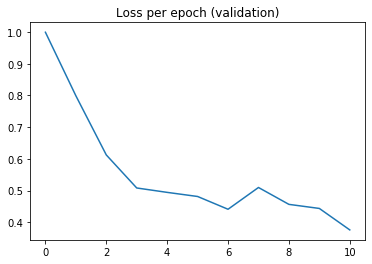

In [ ]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_0.weight_None_4.png


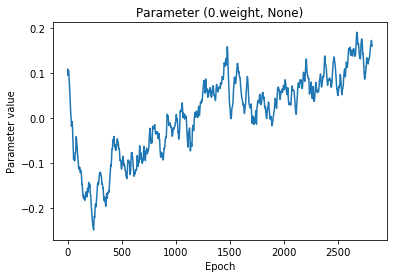

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.embedding_weights_None_4.png


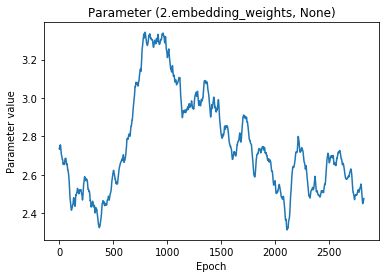

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.block_weights_None_4.png


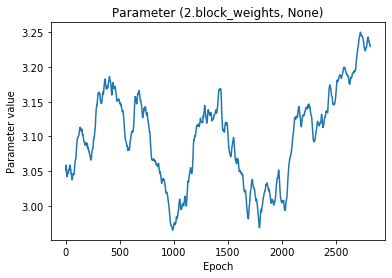

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.weight_None_4.png


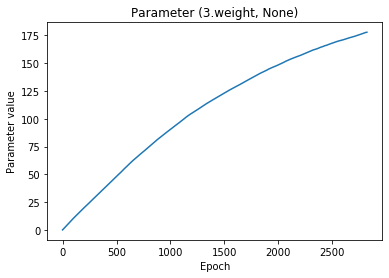

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.bias_None_4.png


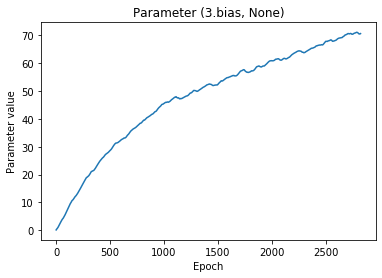

In [ ]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [ ]:
# model.plot_parameter(layer='7.weights', index=50)

In [ ]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0809/models/0809-sh_em_1qm_v2_3.pth


Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_em_1qm_v2_validation_4.png


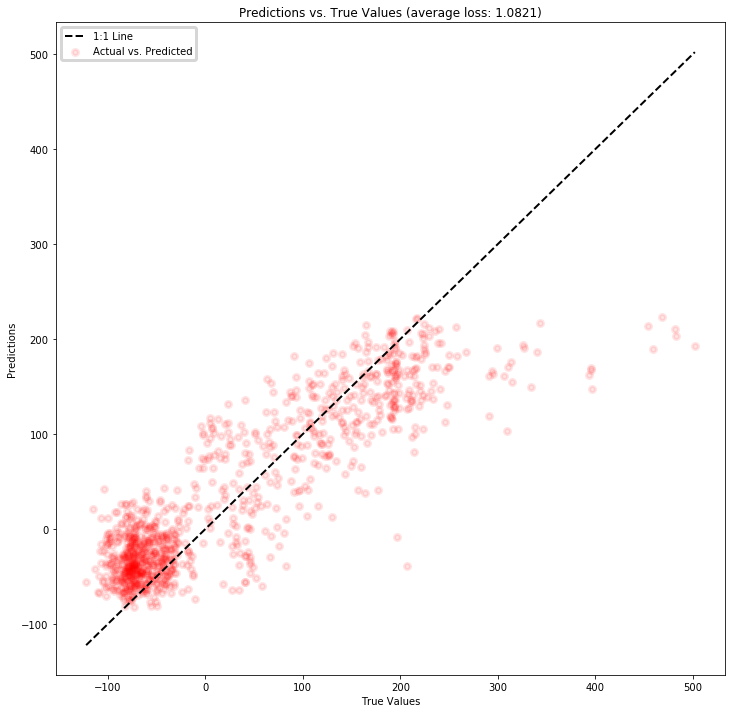

In [ ]:
model.plot_validation(save=True, fig_size=(9,9))

In [ ]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: -78.0800, 	 prediction: -8.6502, 	 loss: 0.8892
i: 1, 		 target: -42.4080, 	 prediction: -30.0594, 	 loss: 0.2912
i: 2, 		 target: 220.1500, 	 prediction: 144.8587, 	 loss: 0.3420
i: 3, 		 target: -69.5500, 	 prediction: -28.4424, 	 loss: 0.5911
i: 4, 		 target: -101.6020, 	 prediction: -48.9109, 	 loss: 0.5186
i: 5, 		 target: -95.9410, 	 prediction: -36.1902, 	 loss: 0.6228
i: 6, 		 target: -83.9420, 	 prediction: -37.2878, 	 loss: 0.5558
i: 7, 		 target: 174.9550, 	 prediction: 191.8207, 	 loss: 0.0964
i: 8, 		 target: 453.8340, 	 prediction: 213.4433, 	 loss: 0.5297
i: 9, 		 target: 213.2580, 	 prediction: 166.9855, 	 loss: 0.2170
i: 10, 		 target: -101.1460, 	 prediction: -25.7691, 	 loss: 0.7452
i: 11, 		 target: -73.6810, 	 prediction: -37.6033, 	 loss: 0.4896
i: 12, 		 target: 51.8760, 	 prediction: -51.9949, 	 loss: 2.0023
i: 13, 		 target: 118.4490, 	 prediction: 127.3110, 	 loss: 0.0748
i: 14, 		 target: -97.8780, 	 prediction: -4.2466, 	 loss: 0.9566
i: 15,

In [ ]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 5e76f65c] data trained model
 14 files changed, 1042 insertions(+), 1 deletion(-)
 create mode 100644 checkpoints/0809/models/0809-sh_em_1qm_v2_3.pth
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_batches_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_losses_epoch_validation_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_0.weight_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.block_weights_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_2.embedding_weights_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.bias_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_parameter_3.weight_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_em_1qm_v2_validation_2.png
 create mode 100644 checkpoints/0809/plots